# Turbidity Mapping: Model Inference and Comparison

This notebook performs **inference and comparison** between a pretrained **4DVarNet** model and two empirical data-driven approaches — **DInEOF** and **eDInEOF** — using CMEMS satellite observations of the Wadden Sea.

We focus on **gap filling** (reconstructing missing satellite pixels) and performance evaluation across models.

---

## 1. Overview and Objectives

Satellite-derived ocean color data (e.g., turbidity or suspended particulate matter – *SPM*) often contain **missing values** due to cloud coverage or sensor limitations.  
To improve the usability of these datasets, we compare three gap-filling techniques:

| Model | Description | Type |
|--------|--------------|------|
| **4DVarNet** | A hybrid physics–AI model trained to reconstruct missing ocean data based on time–space dynamics. | Deep learning |
| **DInEOF** | Data-Interpolating Empirical Orthogonal Functions, a classic method for filling spatial–temporal gaps. | Statistical |
| **eDInEOF** | An extended version of DInEOF with improved temporal coherence. | Statistical |
| **CMEMS** | Copernicus Marine Environment Monitoring Service data (used as reference). | Observational |

---


We need to import the libraries needed here 

In [1]:
# We import the libraries needed for the pipeline
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sp
import time

## 2. Data Description

We use the following datasets (already preprocessed to **log₁₀(SPM)** scale):

| File | Description |
|------|--------------|
| `data/Obs_SPM_log10_aNam.nc` | CMEMS high-resolution ocean color data for the **North West Shelf / Wadden Sea**. This dataset contains many missing values (NaN) due to cloud cover. |
| `data/Obs_SPM_log10_aNam_removed_50percent_patch_again.nc` | Same CMEMS dataset, but with **50% of the valid data removed** to create an artificial test scenario. The removed pixels are reserved for **independent evaluation**. |
| `data/land_mask_OSE.nc` | Land–sea mask (1 over land, NaN over sea). Used to restrict computations to the ocean. |
| `data/checkpoints/val_mse=24.5515-epoch=197.ckpt` | Pretrained 4DVarNet weights (trained on **SCHISM** gap-free simulations). We don’t train directly on CMEMS data because it is ~92% missing, making direct learning impractical. |

> 💡 The pretrained model is later fine-tuned or evaluated on CMEMS data for the same 11-month period (January–November 2020).

---

## 3. Data Download and Visualization

After downloading the files above, you can visualize the datasets to better understand their spatial coverage, gaps, and land–sea configuration.

This helps confirm that:
- The CMEMS data has strong spatial gaps due to clouds.
- The masked dataset removes additional pixels for evaluation.
- The land mask correctly distinguishes sea and land areas.

---

In [2]:
!mkdir -p data
# GT
!wget -q --show-progress 'https://s3.eu-west-2.wasabisys.com/4dvarnet/german-wadden-sea/Obs_SPM_log10_aNam.nc' -O 'data/Obs_SPM_log10_aNam.n'c
# patch
!wget -q --show-progress 'https://s3.eu-west-2.wasabisys.com/4dvarnet/german-wadden-sea/Obs_SPM_log10_aNam_removed_50percent_patch_again.nc' -O 'data/Obs_SPM_log10_aNam_removed_50percent_patch_again.nc'
# Land mask
!wget -q --show-progress 'https://s3.eu-west-2.wasabisys.com/4dvarnet/german-wadden-sea/land_mask_OSE.nc' -O 'data/land_mask_OSE.nc'
# checkpoint
!mkdir -p data/checkpoints
!wget -q --show-progress 'https://s3.eu-west-2.wasabisys.com/4dvarnet/german-wadden-sea/val_mse=24.5515-epoch=197.ckpt' -O 'data/checkpoints/val_mse=24.5515-epoch=197.ckpt'

data/Obs_SPM_log10_ 100%[===================>]  90.69M  56.7MB/s    in 1.6s    
data/Obs_SPM_log10_ 100%[===================>]  90.69M  74.2MB/s    in 1.2s    
data/land_mask_OSE. 100%[===================>] 577.15K  3.29MB/s    in 0.2s    
data/checkpoints/va 100%[===================>]  11.70M  34.1MB/s    in 0.3s    


After the data is downloaded, you can visualize it to get more familiar with it

In [3]:
data_CMEMS = xr.open_dataset(
    "data/"
    + "Obs_SPM_log10_aNam.nc"
)
print("data_CMEMS: ", data_CMEMS)

data_CMEMS_50percentmasked = xr.open_dataset(
    "data/"
    + "Obs_SPM_log10_aNam_removed_50percent_patch_again.nc"
)

print("data_CMEMS_50percentmasked: ", data_CMEMS_50percentmasked)
land_mask=xr.open_dataset(
    "data/"
    + "land_mask_OSE.nc"
)

print("land_mask: ", land_mask)

data_CMEMS:  <xarray.Dataset> Size: 95MB
Dimensions:  (time: 330, lat: 240, lon: 300)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-11-25
  * lat      (lat) float32 960B 55.11 55.1 55.09 55.08 ... 52.64 52.63 52.62
  * lon      (lon) float32 1kB 6.37 6.38 6.391 6.401 ... 9.453 9.464 9.474 9.484
Data variables:
    SPM      (time, lat, lon) float32 95MB ...
Attributes: (12/48)
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    history:                    Fri Feb 23 09:16:37 2024: cdo -remapbil,grid_...
    source:                     Sentinel-2 MSI L1C
    institution:                Brockmann Consult GmbH, RBINS, VITO for CMEMS...
    Conventions:                CF-1.7
    TileSize:                   945:1192
    ...                         ...
    time_coverage_start:        20200101T000000Z
    time_coverage_stop:         20200101T235959Z
    title:                      CMEMS HR-OC North West Shelf Region transpar

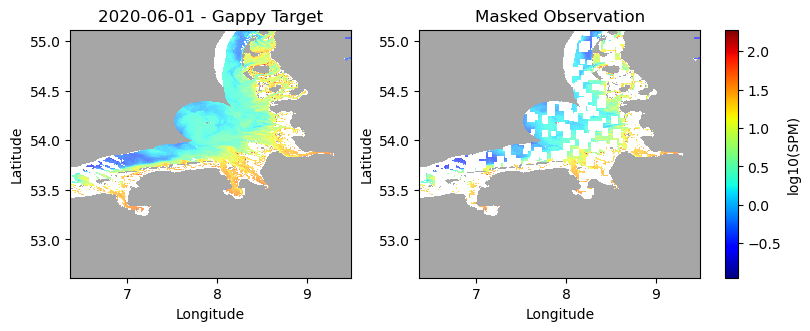

In [4]:
#calling longitude and latitude dimension
lon = data_CMEMS.lon
lat = data_CMEMS.lat
nlat=lat.size
nlon=lon.size

#the min and max value for the color map
v_min=0.0#np.min(data.tgt[rang_min:rang_max:10])
v_max=2.0#np.max(data.tgt[rang_min:rang_max:10])

t=152#the time index that we chose to show here 



# figure of 1 row, 2 columns
fig, axes = plt.subplots(
    1, 2,
    figsize=(2 * 4, 1 * 4 * (nlat / nlon)),  # width scales with #cols
    constrained_layout=True
)

def add_panel(ax, field, title):
    m = ax.pcolormesh(lon, lat, field, cmap='jet', shading='auto')# norm=norm,
    ax.pcolormesh(lon, lat, (land_mask.mask > 0.5), cmap='Greys', vmin=0, vmax=1,
                  shading='auto', alpha=0.35)
    ax.set_title(title)
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    # keep north-up if lat is descending
    # if float(lat[0]) > float(lat[-1]):
    #     ax.invert_yaxis()
    return m


# Left: full / gappy target
m0 = add_panel(
    axes[0],
    data_CMEMS.SPM.isel(time=t),
    f"{data_CMEMS.time.isel(time=t).dt.strftime('%Y-%m-%d').item()} - Gappy Target"
)

# Right: masked observation (use your masked dataset here)
m1 = add_panel(
    axes[1],
    data_CMEMS_50percentmasked.SPM.isel(time=t),
    "Masked Observation"
)

# Shared colorbar on the right
cbar = fig.colorbar(m0, ax=axes, fraction=0.046, pad=0.04)
cbar.set_label("log10(SPM)")

plt.show()

## 5. Inference Using Pretrained 4DVarNet

### Figure 1 — Example of Reconstructed Turbidity Map with Hybrid model approach using 4DVarNet
![4DVarNet Hybrid Model Workflow](img/4dVarNet_workflow.png)

*This figure shows the spatial reconstruction of SPM using the 4DVarNet model.*


### 🔹 Model Setup

We create an output folder `outputs/main/` where all reconstructed (gap-filled) data will be saved.

In [5]:
!rm -rf outputs/main

The inference command is:

```bash
!python main.py xp=test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows hydra.run.dir=./outputs/main
```

Explanation:

 - main.py runs the inference pipeline for 4DVarNet.

 - The configuration file test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows.yaml defines:

- Dataset paths (CMEMS masked files).

- Model parameters (time windows = 10 consecutive days).

- Pretrained weights location.

- Supporting files (data loading, model definition, utilities, metrics) are located in the src/ directory.

 Inference can take several minutes depending on hardware.

 Remark that the time printed below is what measure inferencing time of 4DVarNet for the selected test dataset.

In [6]:
start=time.time()

!python main.py xp=test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows hydra.run.dir=./outputs/main

print(f"Computing time for 4DVarNet: {(time.time() - start)/60:.2f} minutes")

Seed set to 333
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Norm stats (0.8312427997589111, 0.5423846244812012)
Restoring states from the checkpoint path at data/checkpoints/val_mse=24.5515-epoch=197.ckpt
/opt/conda/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:445: The dirpath has changed from '/homes/n23nguye/4dvarnet-starter/outputs/2024-03-12/09-50-58/base_SCHISM_AugPatches_BiggerModel_smallerTimeWindows/TimeWindows10/checkpoints' to '/home/onyxia/work/outputs/main/test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows/TestonOSE_DutchWaddenSea/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at data/checkpoints/val_mse=24.5515-epoch=197.ckpt
/opt/conda/lib/python3.12/site-p

## 5. Time Coverage

The pretrained 4DVarNet model was trained on **SCHISM simulations** covering **11 months of 2020**, from 2020-January-02 to 2020-November 26 
Therefore, we restrict the comparison on CMEMS data to the same period (January–November 2020).


If you wish to process a different time period, you can adjust the dates in the code below.
However, make sure the selected period remains within the available data range — that is, between **January 2 and November 26, 2020**.

---

In [7]:
start_date='2020-01-02'
end_date='2020-11-26'

time_slice = slice(start_date, end_date)
GT = data_CMEMS.sel(time=time_slice)
Masked_Obs = data_CMEMS_50percentmasked.sel(time=time_slice)
data4DVarnet = xr.open_dataset("outputs/main/test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows/TestonOSE_DutchWaddenSea/test_data.nc").sel(time=time_slice)

 ... It could take minutes, be patient ...

## 6. Evaluation Metrics

To evaluate the quality of the reconstructed satellite data, we use two standard metrics that measure both absolute and relative differences between model outputs and reference observations.

| Metric | Description | Scale |
|---------|--------------|--------|
| **RMSE** (Root Mean Square Error) | Measures the average difference between the reconstructed values and the reference CMEMS observations. It is computed in **log₁₀(SPM)** space, which helps reduce the influence of extreme values. | Log scale |
| **RE** (Relative Error) | Measures the average proportional difference, showing how large the reconstruction error is compared to the reference values. | Linear scale |

These metrics help quantify how accurately each model (4DVarNet, DInEOF, eDInEOF) can reconstruct the missing data.

>  **Interpretation:**  
> - A smaller RMSE means better accuracy (closer to CMEMS ground truth).  
> - A smaller RE means lower relative difference between reconstructed and observed values.

---

In [8]:
# The two performance metrics we use for cross-validation in (e)DInEOF algorithms)
def rmse(x,y):
    return np.sqrt(np.mean((x-y)**2))

def RE(gt,pred):
    ep=0.0001
    return np.mean(np.abs((10**gt+ep)-(10**pred+ep))/np.abs(10**gt+ep))*100

## 7. DInEOF and eDInEOF Methods

### DInEOF — *Data-Interpolating Empirical Orthogonal Functions*

DInEOF is a **data-driven statistical technique** commonly used in oceanography to fill missing values in satellite images.  
It reconstructs missing pixels by identifying the main spatial and temporal patterns (Empirical Orthogonal Functions, or EOFs) in the data and using them to estimate gaps.

- **Reference:** Beckers & Rixen (2003), *Ocean Modelling*, DOI: https://doi.org/10.1175/1520-0426(2003)020<1839:ECADFF>2.0.CO;2 
- **Key idea:** the ocean has repeating spatial–temporal patterns (like tides or seasonal changes). EOFs capture these patterns and use them to reconstruct missing regions.

---

In [9]:
# DInEOF algorithm
def DInEOF(X, mask_miss, mask_test=None, k=1, iter_=1000):
    X_rec_temp = np.zeros(X.shape)
    score = np.zeros([3,iter_])
    for i in range(iter_):
        X_rec_out = X_rec_temp.copy()
        X_rec_temp[~mask_miss] = X[~mask_miss].copy()
        #u, s, vh = sp.svds(X_rec_temp,k=k)
        #X_rec_temp = u@np.diag(s)@vh
        A = X_rec_temp.T@X_rec_temp
        p2, v = sp.eigs(A,k)
        if np.sum(np.imag(p2))!=0:
            warning.warn("Caution non-zero imaginary part has been discard")
        p = np.sqrt(np.real(p2))
        v = np.real(v)
        u = X_rec_temp@(v@np.diag(1./p))
        X_rec_temp = u@np.diag(p)@v.T
        score[0,i] = i
        score[1,i] = k
        score[2,i] = rmse(X[mask_test], X_rec_temp[mask_test])
        if i>0:
            if score[2,i]>score[2,i-1]:
                score = score[:,0:i+1]
                return X_rec_out, score
            elif np.abs(score[2,i]-score[2,i-1])<1.e-4:
                k+=1
    X_rec_out = X_rec_temp
    return X_rec_out, score

### eDInEOF (Extended DInEOF)

eDInEOF (A. Alvera-Azcárate, A. Barth, D. Sirjacobs, J.-M. Beckers (2009), https://doi.org/10.5194/os-5-475-2009) is an **improved version of DInEOF** designed to better capture temporal continuity.  
While DInEOF reconstructs each time step independently, eDInEOF introduces additional constraints that make the reconstruction more consistent over time.

This method is used in several **operational ocean color processing chains**, producing Level-4 (gap-free) satellite data products.

>  In this notebook, we use DInEOF and eDInEOF as **baseline statistical methods** to compare against the physics-informed deep learning approach of 4DVarNet.

---

In [10]:
# eDInEOF algorithm 
def eDInEOF(X, mask_miss, mask_test, dt=1, alpha=1.e-2 , s_=5, k=1, iter_=1000):
    N = X.shape[1]
    F = -2*np.eye(N,N)+np.eye(N,N,-1)+np.eye(N,N,1)
    F[1,0] = 2
    F[-2,-1] = 2
    F = (alpha/dt**2)*F
    
    X_rec_temp = np.zeros(X.shape)
    score = np.zeros([3,iter_])    
    for i in range(iter_):
        X_rec_out = X_rec_temp.copy()
        X_rec_temp[~mask_miss] = X[~mask_miss].copy()
        for s in range(s_):
            X_rec_temp = X_rec_temp+X_rec_temp@F
        #u, sigma, vh = sp.svds(X_rec_temp, k=k)
        #X_rec_temp = u@np.diag(sigma)@vh
        A = X_rec_temp.T@X_rec_temp
        p2, v = sp.eigs(A,k)
        if np.sum(np.imag(p2))!=0:
            warning.warn("Caution non-zero imaginary part has been discard")
        p = np.sqrt(np.real(p2))
        v = np.real(v)
        u = X_rec_temp@(v@np.diag(1./p))
        X_rec_temp = u@np.diag(p)@v.T
        score[0,i] = i
        score[1,i] = k
        score[2,i] = rmse(X[mask_test], X_rec_temp[mask_test])
        if i>0:
            if score[2,i]>score[2,i-1]:
                score = score[:,0:i+1]
                return X_rec_out, score
            elif np.abs(score[2,i]-score[2,i-1])<1.e-4:
                k+=1
    X_rec_out = X_rec_temp
    return X_rec_out, score
    

### The Below three cells are for processing DInEOF and eDInEOF

In [11]:
#This cell is to prepare for computing DInEOF and eDInEOF
start = time.time()#to measure computing time of DInEOF
var = 'SPM'

#OSE
data = Masked_Obs


nlat = data.lat.size
nlon = data.lon.size

nb_sea_pix = np.sum(np.isnan(land_mask.mask.values)) # Nb of sea pixels to be filled
idx_sea = np.isnan(land_mask.mask.values.flatten()) # Sea pixels locations

dt = len(data.time) # Length of the time-serie
X = np.full([nb_sea_pix,dt],np.nan) # Init. of the matrix to store vectorized sea-pixels

# Loop to build the data matrix to be used in completion algorithms
for t in range(dt):
    data_t = data[var][t].values.flatten()
    X[:,t] = data_t[idx_sea]
    
mask_mv = np.isnan(X) # Missing data mask matrix
mask_data = 1-mask_mv # Data mask matrix
data_index = np.where(mask_data) # Data index

mask_crossval = np.full([nb_sea_pix,dt], False, dtype=bool) # Init. mask matrix for cross-validation data
rand_pick = np.random.permutation(data_index[0].size)[0:int(.01*data_index[0].size)]
data_pick = (data_index[0][rand_pick],data_index[1][rand_pick]) # Random selection of data for cros-validation (1%)
mask_crossval[data_pick] = True

mask_mv[mask_crossval] = True

# Data normalization
mu = np.nanmean(X)
std = np.nanstd(X)**2
X = (X-mu)/std
X = np.where(np.isnan(X),0,X)

In [12]:
# Apply DInEOF to the selected data

X_rec, score = DInEOF(X, mask_mv, mask_crossval)
X_rec = X_rec*std+mu

# Reshaping
rec_DInEOF = np.zeros([dt,nlat,nlon])
for t in range(dt):
    data_t = np.full([nlat*nlon], np.nan)
    data_t[idx_sea] = X_rec[:,t]
    rec_DInEOF[t] = data_t.reshape(nlat,nlon)

#saving reconstruction    
rec_DInEOF = xr.DataArray(rec_DInEOF,name=var,coords=[data.time[0:dt],data.lat,data.lon],dims=['time','lat','lon'])
rec_DInEOF.to_netcdf('data/DInEOF_log10.nc')

print(f"Computing time for DInEOF: {(time.time() - start)/60:.2f} minutes")


Computing time for DInEOF: 0.70 minutes


In [13]:
# Apply eDInEOF to the selected data
start=time.time()
X_rec, score_e = eDInEOF(X, mask_mv, mask_crossval)
X_rec = X_rec*std+mu

# Reshaping
rec_eDInEOF = np.zeros([dt,nlat,nlon])
for t in range(dt):
    data_t = np.full([nlat*nlon], np.nan)
    data_t[idx_sea] = X_rec[:,t]
    rec_eDInEOF[t] = data_t.reshape(nlat,nlon)
    
# saving reconstruction
rec_eDInEOF = xr.DataArray(rec_eDInEOF,name=var,coords=[data.time[0:dt],data.lat,data.lon],dims=['time','lat','lon'])
rec_eDInEOF.to_netcdf('data/eDInEOF_log10.nc')

print(f"Computing time for eDInEOF: {(time.time() - start)/60:.2f} minutes")


Computing time for eDInEOF: 1.89 minutes


# Compute the RMSE, RE of the three algorithms
To compute this the original observations CMEMS is considered as ground truth (GT). And The 50 % masked obseration CMEMS data is used as input (Masked_Obs). The metrics are computed only on the 50% held out pixels that are unseen to all methods.

In [14]:
#load the data
rec_DInEOF = xr.open_dataset('data/DInEOF_log10.nc')
rec_eDInEOF = xr.open_dataset('data/eDInEOF_log10.nc')

#declare the pixels in which we process RMSE and RE
mask_obs_minus_GT = ~np.isnan(GT.SPM.values) & np.isnan(Masked_Obs.SPM)#mask_obs_minus_GT = True if Masked_Obs is nan and GT is not nan (and False otherwise)

#score_DInEOF 
score_DInEOF = rmse(GT.SPM.values[mask_obs_minus_GT],rec_DInEOF.SPM.values[mask_obs_minus_GT])
print("RMSE DinEOF: ",score_DInEOF)

#RE_DInEOF
RE_DInEOF = RE(GT.SPM.values[mask_obs_minus_GT],rec_DInEOF.SPM.values[mask_obs_minus_GT])
print("RE DinEOF: ", RE_DInEOF)

#score_eDInEOF 
score_eDInEOF = rmse(GT.SPM.values[mask_obs_minus_GT],rec_eDInEOF.SPM.values[mask_obs_minus_GT])
print("RMSE eDinEOF: ",score_eDInEOF)

#RE_eDInEOF
RE_eDInEOF = RE(GT.SPM.values[mask_obs_minus_GT],rec_eDInEOF.SPM.values[mask_obs_minus_GT])
print("RE eDinEOF: ",RE_eDInEOF)

#score_4DVarNetwith
score_4DVarNet = rmse(GT.SPM.values[mask_obs_minus_GT],data4DVarnet.out.values[mask_obs_minus_GT])
print("RMSE 4DVarNEt: ",score_4DVarNet)

#RE_4DVarNet
RE_4DVarNet = RE(GT.SPM.values[mask_obs_minus_GT],data4DVarnet.out.values[mask_obs_minus_GT])
print("RE 4DVarNEt: ",RE_4DVarNet)


RMSE DinEOF:  0.1769813591346307
RE DinEOF:  33.155178173792386
RMSE eDinEOF:  0.17166833792426772
RE eDinEOF:  32.01667123679843
RMSE 4DVarNEt:  0.15532846355204524
RE 4DVarNEt:  26.204756042937188


## 8. Visualization: Spatial Reconstruction

Once all models have produced their gap-filled datasets, we visualize the results to understand their differences in space.

The following maps are shown for a selected day:

1. **Gappy CMEMS** — the original observation, with natural gaps due to clouds.  
2. **Masked CMEMS** — the same dataset with 50% additional pixels artificially removed (used for testing).  
3. **DInEOF** — reconstruction using the EOF-based approach.  
4. **eDInEOF** — reconstruction with temporal constraints.  
5. **4DVarNet** — reconstruction using the physics–AI hybrid model.

Each subplot uses the same **color scale (`log₁₀(SPM)`)** to make visual comparison fair.  
The **land mask** (in gray) helps distinguish ocean pixels from land areas.

>  These visualizations provide an intuitive way to assess how well each model recovers the spatial structures of turbidity in the Wadden Sea.

---

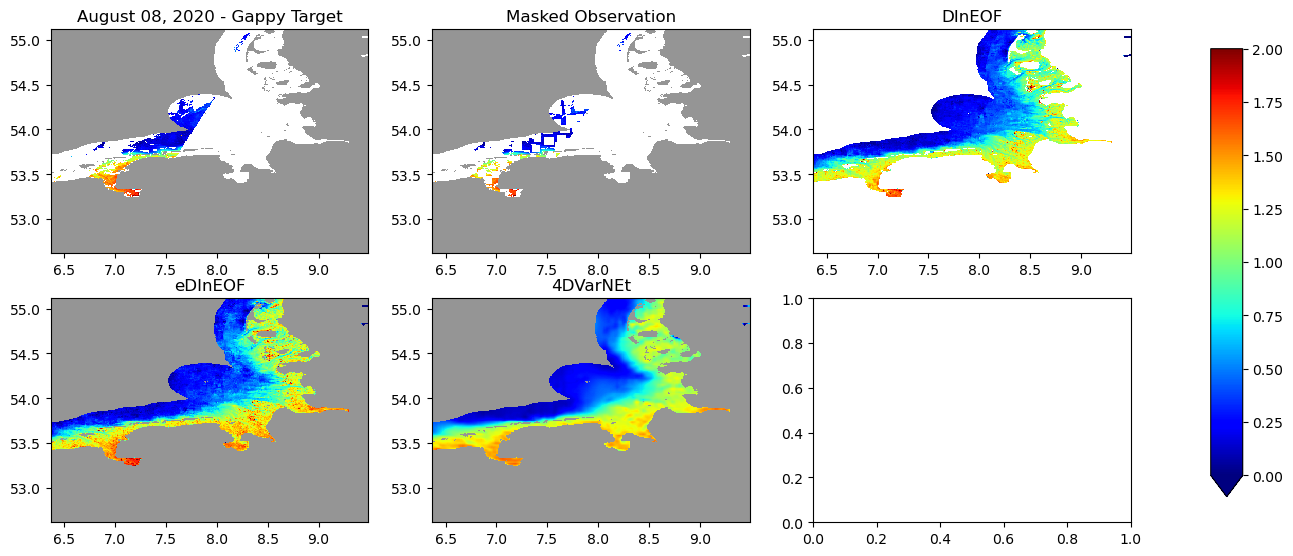

In [15]:
#plot all algorithms for some specific days
t=219# the time index (which day you want to plot)#156, 221

# transpose land_mask
land_mask_transposed = land_mask.transpose('lat', 'lon')


plots_path='plots'
import os
if not os.path.exists(plots_path):
    os.makedirs(plots_path)

fig, axes = plt.subplots(2, 3, figsize=(4 * 4, 2 * 4 * (nlat / nlon)))  # Adjust size as needed for 2 rows, 3 columns


# First subplot (Row 1, Column 1)
mappable0 = axes[0, 0].pcolormesh(lon, lat, GT.SPM[t], cmap='jet', vmin=v_min, vmax=v_max)
axes[0, 0].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax=2)
axes[0, 0].set_title(GT.time[t].dt.strftime("%B %d, %Y").values + " - Gappy Target")


# Second subplot (Row 1, Column 2)
mappable1 = axes[0, 1].pcolormesh(lon, lat, Masked_Obs.SPM[t], cmap='jet', vmin=v_min, vmax=v_max)
axes[0, 1].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax=2)
axes[0, 1].set_title("Masked Observation")


# Third subplot (Row 1, Column 3)
# If you have a third type of data for this row, use it here
# Example:
mappable2 = axes[0, 2].pcolormesh(lon, lat, rec_DInEOF.SPM.values[t], cmap='jet', vmin=v_min, vmax=v_max)
axes[0, 1].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax=2)
axes[0, 2].set_title("DInEOF")


# Fourth subplot (Row 2, Column 1)
mappable3 = axes[1, 0].pcolormesh(lon, lat, rec_eDInEOF.SPM.values[t], cmap='jet', vmin=v_min, vmax=v_max)
axes[1, 0].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax=2)
axes[1, 0].set_title("eDInEOF")


# Fifth subplot (Row 2, Column 2)
mappable4 = axes[1, 1].pcolormesh(lon, lat, data4DVarnet.out[t], cmap='jet', vmin=v_min, vmax=v_max)
axes[1, 1].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax=2)
axes[1, 1].set_title("4DVarNEt")


# Colorbar setup
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])  # Position for the colorbar
fig.colorbar(mappable0, cax=cbar_ax, extend='min')


# Save the figure
fig.savefig(f"plots/plot_4DVarNet_vs_Unet_vs_DinEOF_SCHISM_time{t}.png", dpi=300)


plt.show()


## 9. Time-Series Comparison (March–October 2020)

Spatial maps give only a snapshot in time.  
To assess **temporal consistency**, we compute and plot a **time series** of ocean-averaged SPM values between **March and October 2020**. You can customize the time period in case you want to zoom in or zoom out the time duration. 

This comparison includes four datasets:

- **CMEMS (ground truth)** — reference observation.  
- **Masked CMEMS** — input data with 50% missing values.
- **4DVarNet** — 4DVarNet (AI model) reconstruction.  
- **DInEOF** — statistical reconstruction.  
- **eDInEOF** — extended statistical reconstruction.  

Each line in the plot represents the value of station pixel for each day. The longitude and latitude of the pixel are shown in the first two lines.

This helps us observe how well each method follows the real temporal variability in turbidity.

>  **Goal:** The closer the reconstructed time series is to CMEMS (GT), the better the model’s performance.

---

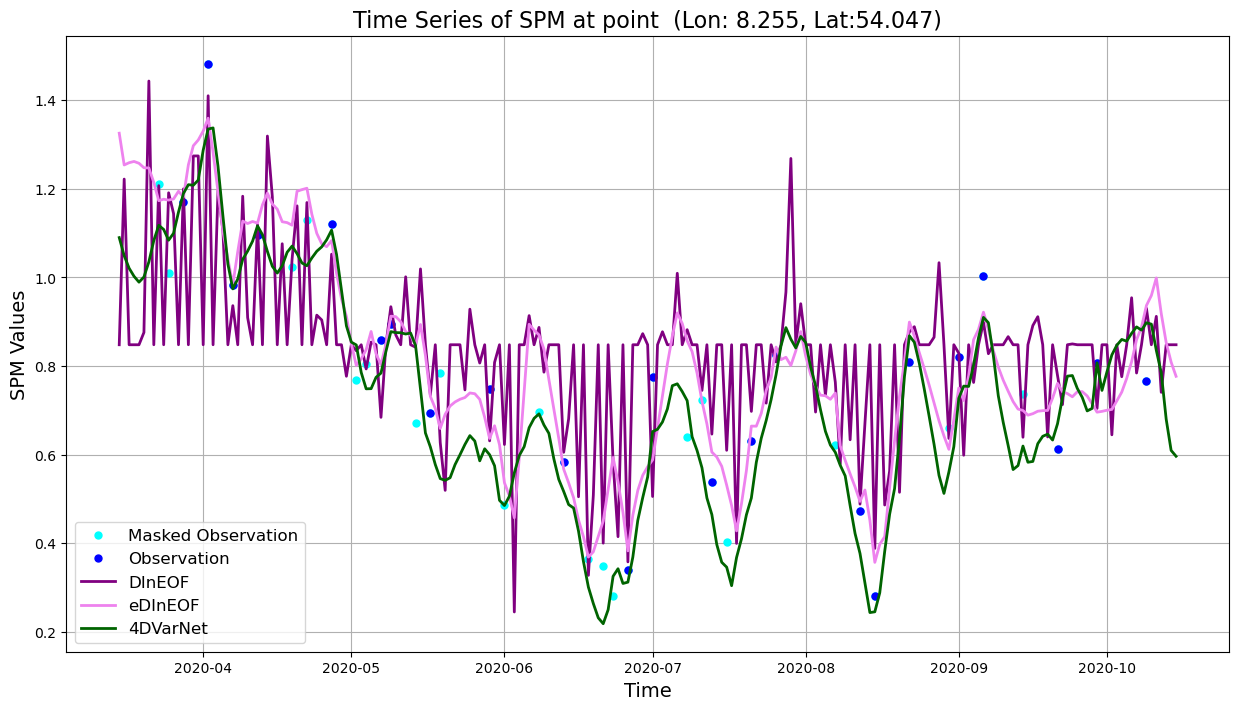

In [16]:
station_lon = 8.255
station_lat =54.047

time_slice = slice('2020-03-15', '2020-10-15')



GT = GT.sel(time=time_slice)
Masked_Obs = Masked_Obs.sel(time=time_slice)
rec_DInEOF = rec_DInEOF.sel(time=time_slice)
rec_eDInEOF = rec_eDInEOF.sel(time=time_slice)
data4DVarnet = data4DVarnet.sel(time=time_slice)

def get_nearest_point(dataset, lon, lat):
    """Find the nearest point in the xarray dataset to the given lon, lat."""
    return dataset.sel(
        lon=lon, lat=lat, method="nearest"
    )  # Nearest method selects the closest grid point
# Extract data for the station TEXSM from each xarray dataset
datasets = {
    "Masked Observation": GT.SPM,
    "Observation": Masked_Obs.SPM,
    "DInEOF": rec_DInEOF.SPM,
    "eDInEOF": rec_eDInEOF.SPM,
    "4DVarNet": data4DVarnet.out,
}

time_series = {
    name: get_nearest_point(ds, station_lon, station_lat)
    for name, ds in datasets.items()
}


# Define new colors for groups
colors = {
    "Masked Observation": "cyan",
    "Observation": "blue",
    "DInEOF": "purple",  # Changed to shades of purple
    "eDInEOF": "violet",
    "4DVarNet": "darkgreen",
}

# Plotting the time series for all datasets
plt.figure(figsize=(15, 8))

for name, series in time_series.items():
    if name in [ "Masked Observation", "Observation"]:
        # Dot marker for sparse data
        plt.plot(
            series.time,
            series.values,
            'o',
            label=name,
            markersize=5,
            color=colors[name],
        )
    else:
        # Line for other datasets
        plt.plot(
            series.time,
            series.values,
            label=name,
            linewidth=2,
            color=colors[name],
        )

# Add labels, legend, and title
plt.xlabel("Time", fontsize=14)
plt.ylabel("SPM Values", fontsize=14)
plt.title(f"Time Series of SPM at point  (Lon: {station_lon}, Lat:{station_lat})", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)

# Save and display the figure
# plt.savefig(f"plots_paperhybridmodels/plot__time_series_DWS_Conv2Donly_texsm.png", dpi=300)
plt.show()


## 10. Summary of Results

The comparison between all methods can be summarized as follows:

| Method | Strengths | Limitations |
|---------|------------|-------------|
| **4DVarNet** | Physically consistent temporal evolution, provide smooth reconstructions and more accurate in term of metrics (root mean square error and relative error) | Requires pretrained weights, struggle with extreme values.|
| **DInEOF / eDInEOF** | Easy to apply; performs well for moderate gaps. | Struggles temporal dynamic, especially DInEOF. |
| **Masked CMEMS** | Serves as baseline for evaluating missing data impacts. | Contains extensive gaps due to cloud coverage. |

### Key Takeaways

- **4DVarNet** achieves the most robust and realistic reconstructions.  
- **DInEOF** and **eDInEOF** provide reasonable results but lack the dynamic consistency and smooth reconstruction of deep learning models.  
- Combining data-driven and physics-based approaches (like 4DVarNet) offers promising potential for **operational turbidity mapping**.

### Next Steps

- Extend the comparison to longer time series and multiple years.  
- Quantitatively benchmark methods over different regions and cloud conditions.  
- Improve the Integratation of 4DVarNet into the **EDITO Model Lab** infrastructure for scalable deployment.

---